# Common Raster Tasks


### Convert NetCDF data to geotiff

How to extract data from netcdf files (local or remote) and convert it into a geotiff.


### Intersect rasters with vector data

Example of how to take a file containing vector format data (e.g. projected polygons), overlay them onto an array (raster) extracted from either a tiff or netcdf, and extract statistics from the intersecting area.


### Minify rasters

In order to work with rasters, we will often have to minify/lightweight the files. This notebook shows an example of how to do this, using the Rasterio sample data. It involves 1) re-scaling the data to fit an int8 (0-255) representation, and compressing the data (using zip or lzw compression).

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import rasterio
from hurry.filesize import size, alternative, verbose
from colorama import Fore, Back, Style
from tqdm import tqdm
%matplotlib inline

In [ ]:
with rasterio.open('./data/RGB.byte.tif') as src:
    profile = src.profile
    transform = src.transform
    r, g, b = src.read()

In [ ]:
# Preview data with Matplotlib 
img = mpimg.imread('./data/RGB.byte.tif')
plt.imshow(img)

In [ ]:
r.max()

## Work from a NetCDF File

Using smarter axis manipulation, like pandas, we can use [Xray](http://nbviewer.jupyter.org/github/nicolasfauchereau/metocean/blob/master/notebooks/xray.ipynb) (formerlly xarray).

In [1]:
import xarray as xr

In [13]:
# For plotting and display
import cartopy.crs as ccrs  # Cartopy project http://scitools.org.uk/cartopy/
import matplotlib.pyplot as plt
from matplotlib.pyplot import cm
%matplotlib inline

In [ ]:
# Connect to a dataset
ncfile = xr.open_dataset("./data/modis_example.nc")

In [ ]:
# Introspect the top level of a connected dataset
ncfile

In [ ]:
# Access metadata layer of a specific variable in a connected dataset
ncfile.Cloud_Fraction_Mean_Mean

In [ ]:
# We can use an equivalent of matplotlib's IMSHOW function to quick view the data array
ncfile.Cloud_Fraction_Mean_Mean[:].plot()

In [ ]:
# or plot just a slice across longitude
ncfile.Cloud_Fraction_Mean_Mean[0].plot()

In [ ]:
# You can use the attributes to access the array directly
# for example, using every (:) latitude, and the -0.5 longitude as indexes.

ncfile.Cloud_Fraction_Mean_Mean.loc[:,-0.5].plot()

In [ ]:
# Elegantly, you can pass a dictionary with the attribute and coordinate specified as an index
pixel = ncfile.Cloud_Fraction_Mean_Mean.loc[{'lat': -0.5, 'lon':-177.5}]
pixel

In [ ]:
# Grouping by attributes is also easy, for example if we need to group the data by latitude:

lat_mean =ncfile.Cloud_Fraction_Mean_Mean.groupby('lat').mean()
lat_max =ncfile.Cloud_Fraction_Mean_Mean.groupby('lat').max()
lat_min =ncfile.Cloud_Fraction_Mean_Mean.groupby('lat').min()

lat_mean.plot(color='r')
lat_max.plot(color='r',ls='--', lw=0.75)
lat_min.plot(color='r',ls='--', lw=0.75)
plt.xlim(-90,90)

# In this way, it would be possible to mainipulate time dimensions to create seasonal data

In [ ]:
# We can also easily create a more advanced preview plot with boundaries projected using cartopy
plt.figure(figsize=(10,7))
ax = plt.axes(projection=ccrs.PlateCarree());
ncfile.Cloud_Fraction_Mean_Mean.plot.pcolormesh(ax=ax, x='lon', y='lat', add_colorbar=False, cmap=cm.gist_earth)
ax.coastlines()
plt.tight_layout()

### Connect to a remote NetCDF file (accessible via OpenDAP)

The [OpenDAP framnework](http://www.opendap.org) enables us to connect to remote datasets painlessly.
We should have this out-of-the box with NetCDF libraries.

Many data centers list their OpenDAP exposed data, e.g. more info at:
* https://disc.sci.gsfc.nasa.gov/disc/services/opendap/
* https://www.esrl.noaa.gov/psd/data/gridded/using_dods.html
* https://www.esrl.noaa.gov/psd/thredds/dodsC/Datasets/
* https://www.unidata.ucar.edu/software/netcdf/docs/dap_accessing_data.html

In [8]:
url = 'http://coastwatch.pfeg.noaa.gov/erddap/griddap/ncdcOisst2Agg'
ncexample = xr.open_dataset(url)

In [9]:
ncexample

<xarray.Dataset>
Dimensions:    (altitude: 1, latitude: 720, longitude: 1440, time: 12990)
Coordinates:
  * time       (time) datetime64[ns] 1981-09-01 1981-09-02 1981-09-03 ...
  * altitude   (altitude) float32 0.0
  * latitude   (latitude) float32 -89.875 -89.625 -89.375 -89.125 -88.875 ...
  * longitude  (longitude) float32 0.125 0.375 0.625 0.875 1.125 1.375 1.625 ...
Data variables:
    sst        (time, altitude, latitude, longitude) float64 ...
    anom       (time, altitude, latitude, longitude) float64 ...
    err        (time, altitude, latitude, longitude) float64 ...
    ice        (time, altitude, latitude, longitude) float64 ...
Attributes:
    cdm_data_type: Grid
    Contact: Dick Reynolds, email: Richard.W.Reynolds@noaa.gov & Chunying Liu, email: Chunying.liu@noaa.gov
    contributor_name: NOAA NCDC
    contributor_role: Source of data.
    Conventions: COARDS, CF-1.6, ACDD-1.3
    creation_date: 2017-01-19 11:10
    Easternmost_Easting: 359.875
    geospatial_lat_max: 

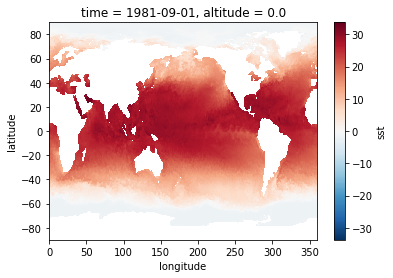

In [14]:
ncexample.sst[0,0,:,:].plot()

### Minify the data

Describe here how to convert float values to int8 (depending on project goals).

### Convert Netcdf to GeoTIFF

Decribe here how to extract the array and relevant metadata from a netcdf, and save to GeoTIFF format with compression for efficent upload to web-mapping services.